# Definindo uma Arquitetura no PyTorch

Para fins didáticos, vamos supor que queremos classificar os seguintes dados: <br>
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html

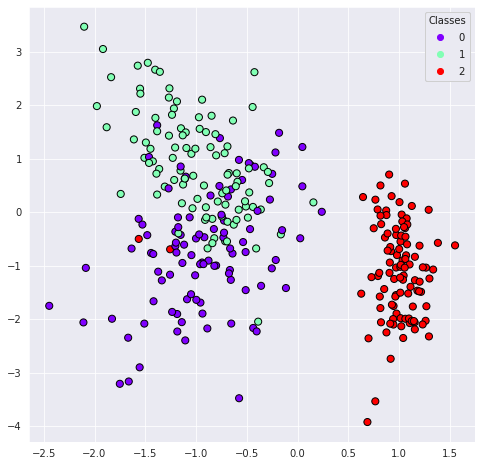

In [50]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('darkgrid')
np.random.seed(12)

X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, n_classes=3, n_samples=300)
X1 = X1.astype(np.float32)
fig, axs = plt.subplots(figsize=(8, 8))
scatter = axs.scatter(X1[:, 0], X1[:, 1], marker='o', 
 c=Y1, s=50, edgecolor='k', cmap='rainbow')

legend1 = axs.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
axs.add_artist(legend1)

# Arquitetura

Vamos implementar a seguinte arquitetura:

<img src="https://github.com/peixebabel/RedesNeuraisPyBR/blob/main/figs/arquitetura.png?raw=true" alt="Arquitetura" width="600px;"/>

Lembrando que: <br>
- Toda camada escondida deve ser seguida de uma ativação não linear
  - nn.ReLU()
- Por se tratar de um problema de classificação, a última camada deve ser ativada.
  - nn.Softmax()

## nn.Sequential

O módulo ```nn.Sequential``` é um container onde se pode colocar múltiplos módulos. Ao realizar um ```forward``` em um objeto ```Sequential``` ele aplicará sequencialmente os módulos nele contidas para gerar uma saída.

Segue abaixo um exemplo desse módulo contendo 2 camadas ```Linear``` intercaladas por uma função de ativação ```ReLU```.

In [57]:
import torch
from torch import nn # neural networks

input_size = 2  # Dimensão do dado
hidden_size = [4, 5, 4] 
output_size = 3

net = nn.Sequential(nn.Linear(input_size, hidden_size[0]),        # hidden1 (escondida)
                    nn.ReLU(),  
                    nn.Linear(hidden_size[0], hidden_size[1]),    # hidden2 (escondida)
                    nn.ReLU(),   
                    nn.Linear(hidden_size[1], hidden_size[2]),    # hidden3 (escondida)
                    nn.ReLU(),   
                    nn.Linear(hidden_size[2], output_size),       # output (saída)
                    nn.Softmax(dim=-1))       
print(net)

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): ReLU()
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): Softmax(dim=-1)
)


O módulo ```summary``` da biblioteca **```torchsummary```** nos permite visualizar mais informações sobre a nossa rede, como quantidade de parâmetros e o tamanho que cada elemento ocupa na memória.

Para mais informações, acesse: https://github.com/sksq96/pytorch-summary

In [55]:
from torchsummary import summary
summary(net, input_size=(1, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 4]              12
              ReLU-2                 [-1, 1, 4]               0
            Linear-3                 [-1, 1, 5]              25
              ReLU-4                 [-1, 1, 5]               0
            Linear-5                 [-1, 1, 4]              24
              ReLU-6                 [-1, 1, 4]               0
            Linear-7                 [-1, 1, 3]              15
           Softmax-8                 [-1, 1, 3]               0
Total params: 76
Trainable params: 76
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


### Forward
Para usar a sua rede no processamento de um conjunto de dados, basta chamá-la como função e passar os dados como parâmetro.

A entrada deve estar no formato **```(B, F)```**
- B (```batch_size```): quantidade de amostras que serão processadas simultaneamente
- F (```feature_size```): dimensões de uma única entrada (vetor: 1, matriz: 2, etc.)

In [58]:
tensor = torch.from_numpy(X1)
print('Entrada (size): ', tensor.size())
pred   = net(tensor)
print('Saída (size):', pred.size())

Entrada (size):  torch.Size([300, 2])
Saída (size): torch.Size([300, 3])


## Classe nn.Module

A forma mais organizada de definir modelos em PyTorch é implementando uma classe nos moldes da classe ```nn.Module```. Para redes pequenas, como as que estamos aprendendo até o momento, sua importância pode não se destacar, mas modelos maiores e com funcionalidades mais complexas, são mais fáceis de implementar e realizar manutenções dessa forma.

Funções obrigatórias do ```nn.Module```.
* ```__init()__```: definição de hiperparâmetros e instância do modelo 
* ```forward()```: Fluxo da entrada para produzir uma saída

In [62]:
import torch.nn.functional as F

class MinhaRede(nn.Module):
  
  def __init__(self, input_size, hidden_size, output_size):
    super(MinhaRede, self).__init__()
    
    # Definir a arquitetura
    self.hidden1 = nn.Linear(input_size, hidden_size[0])
    self.hidden2 = nn.Linear(hidden_size[0], hidden_size[1])
    self.hidden3 = nn.Linear(hidden_size[1], hidden_size[2])
    self.output = nn.Linear(hidden_size[2], output_size)
    
  def forward(self, X):
    
    # Gerar uma saída a partir do X
    hidden = F.relu(self.hidden1(X))
    hidden = F.relu(self.hidden2(hidden))
    hidden = F.relu(self.hidden3(hidden))
    
    output = F.softmax(self.output(hidden), dim=-1)
    
    return output

### Instanciando a rede

In [64]:
input_size = 2
hidden_size = [4, 5, 4] 
output_size = 3

net = MinhaRede(input_size,hidden_size, output_size)  ## Roda o método __init__()
print(net)

MinhaRede(
  (hidden1): Linear(in_features=2, out_features=4, bias=True)
  (hidden2): Linear(in_features=4, out_features=5, bias=True)
  (hidden3): Linear(in_features=5, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=3, bias=True)
)


### Forward

In [65]:
tensor = torch.from_numpy(X1)
print('Entrada (size): ', tensor.size())
pred   = net(tensor) ## Roda o método forward()
print('Saída (size):', pred.size())

Entrada (size):  torch.Size([300, 2])
Saída (size): torch.Size([300, 3])


## Subindo informações na GPU

Para conseguir executar modelos maiores em tempo hábil, é preciso carregar as informação na GPU para que o processamento seja realizado por ela. Dentre as informações que conhecemos até o momento, duas delas precisam ser carregadas na GPU:
* Entrada
* **Rede**



> Atenção: Altere as configurações do notebook para acessar a GPU no colab
```bash
Editar > Configurações de Notebook > GPU
```

In [66]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# Instanciando a rede
net = MinhaRede(input_size,hidden_size, output_size)
net.to(device) #####

# Forward
tensor = torch.from_numpy(X1)
tensor = tensor.to(device) #####
print(tensor[0], '\n')

print('Entrada (size): ', tensor.size())
pred   = net(tensor)
print('Saída (size):', pred.size())

cpu
tensor([-0.6910,  1.2284]) 

Entrada (size):  torch.Size([300, 2])
Saída (size): torch.Size([300, 3])


## Bonus: Modelos pré-treinados do PyTorch

https://pytorch.org/docs/stable/torchvision/models.html

O pacote **Torchvision** Pytorch possui modelos **pré-treinados** para diversos problemas com imagens:
- Classificação de Imagens
- Classificação de Vídeos
- Detecção de objetos
- Segmentação semântica
- etc.

Esses modelos podem ser carregados com uma única linha de código :)

In [ ]:
import torchvision

net = torchvision.models.alexnet(pretrained=True)
summary(net, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25